In [2]:
import estimator
import numpy as np
import matplotlib.pyplot as plt
# Global Settings for Matplotlib
plt.rcParams.update({
    'text.usetex': False,              # Enable LaTeX rendering for text
    'font.family': 'serif',           # Set font family
    'font.size': 13,                  # General font size
    'lines.markersize': 10,           # Default marker size
    'legend.fontsize': 'small',       # Legend font size
    'legend.frameon': False,          # Remove frame around legend
    'figure.figsize': (6, 4),         # Default figure size
    'axes.grid': True,                # Enable grid for axes
    'grid.alpha': 0.1,                # Set grid transparency
    'grid.linestyle': '--',           # Set grid line style
    'grid.color': 'gray',             # Set grid line color
    'axes.grid.which': 'both',        # Enable both major and minor gridlines
    'axes.grid.axis': 'both',         # Apply grid to both x and y axes
    'axes.labelsize': 13,             # Font size for axis labels
    'xtick.labelsize': 10,            # Font size for x-axis tick labels
    'ytick.labelsize': 10             # Font size for y-axis tick labels
})



In [3]:
import random
import importlib
from tqdm import tqdm

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x) ** 2
    sin_wx_squared = np.sin(w * x) ** 2
    exp_ax = np.exp(a * x)

    term1 = x ** 2 * cos_wx_squared / (exp_ax + np.cos(w * x)) ** 2
    term2 = x ** 2 * sin_wx_squared / (exp_ax + np.cos(w * x)) ** 2

    return term1 + term2


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

In [4]:
import numpy as np


def p(t, w, a):
    return 1 / 2 * (1 + np.cos(w * t) * np.exp(-a * t))


def pw(t, w, a):
    return - 1 / 2 * t * np.sin(w * t) * np.exp(-a * t)


def pww(t, w, a):
    return - 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def pa(t, w, a):
    return - 1 / 2 * t * np.cos(w * t) * np.exp(-a * t)


def paa(t, w, a):
    return 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def paw(t, w, a):
    return 1 / 2 * t ** 2 * np.sin(w * t) * np.exp(-a * t)


def fisher_matrix(t, w, a, shots):
    Iww = 0
    Iaa = 0
    Iwa = 0

    for i in range(len(t)):
        p0 = p(t[i], w, a)
        p1 = 1 - p0
        pw0 = pw(t[i], w, a)
        pw1 = -pw0
        pww0 = pww(t[i], w, a)
        pww1 = -pww0
        pa0 = pa(t[i], w, a)
        pa1 = -pa0
        paa0 = paa(t[i], w, a)
        paa1 = -paa0
        paw0 = paw(t[i], w, a)
        paw1 = -paw0

        if p0 == 0:
            p0 = 1e-10
        if p1 == 0:
            p1 = 1e-10

        # Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
        #                                                                     ** 2) / p1 ** 2))
        # Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
        # Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        Iww += shots[i] * (p0 * ((pw0 ** 2) / p0 ** 2) + p1 * ((pw1 ** 2) / p1 ** 2))
        Iaa += shots[i] * (p0 * ((pa0 ** 2) / p0 ** 2) + p1 * ((pa1 ** 2) / p1 ** 2))
        Iwa += shots[i] * (p0 * ((pw0 * pa0) / p0 ** 2) + p1 * ((pw1 * pa1) / p1 ** 2))
    return np.array([[Iww, Iwa], [Iwa, Iaa]])



def lower_bound(f_mat):
    inv = np.linalg.inv(f_mat)
    inv = inv.reshape(2,2)
    w_var = np.sqrt(inv[0, 0])
    a_var = np.sqrt(inv[1, 1])

    #a_var = np.sqrt(inv[1, 1])
    return w_var, a_var



In [5]:
from scipy.optimize import minimize


def find_optimal_times(W, A, N, Total_Shots=1000):
    def model_func(params):
        t = params[0:N]
        shots = params[N:2 * N]
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                p0 = p(t[i], w, a)
                p1 = 1 - p0
                pw0 = pw(t[i], w, a)
                pw1 = -pw0
                pww0 = pww(t[i], w, a)
                pww1 = -pww0
                pa0 = pa(t[i], w, a)
                pa1 = -pa0
                paa0 = paa(t[i], w, a)
                paa1 = -paa0
                paw0 = paw(t[i], w, a)
                paw1 = -paw0

                if p0 == 0:
                    p0 = 1e-10
                if p1 == 0:
                    p1 = 1e-10

                Iww[j] -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
                                                                                    ** 2) / p1 ** 2))
                Iaa[j] -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
                Iwa[j] -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        lower_w_bound = np.sum([1000 * Iaa[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([1000 * Iww[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return  np.mean([lower_w_bound,lower_a_bound])

    def shots_constraint(params):
        return np.sum(params[N:2 * N]) - Total_Shots

    # Define the constraint as a dictionary
    cons = ({'type': 'eq', 'fun': shots_constraint})
    initial_guess = np.concatenate([np.random.uniform(0, 1, N), np.full(N, Total_Shots / N)])
    result = minimize(model_func, initial_guess, method='trust-constr', bounds=[(0, 6)] * N + [(0, 1000)] * N,
                      constraints=cons)
    return result.x


def process_result(result):
    times = result[0:N]
    shots = result[N:2 * N]

    grouped_times = []
    grouped_shots = []

    for i in range(len(times)):
        for j in range(len(grouped_times)):
            if abs(grouped_times[j] - times[i]) < 0.01: #change to 0.005
                #grouped_times.append(times[i])
                grouped_shots[j] += shots[i]
                break
        else:
            grouped_times.append(times[i])
            grouped_shots.append(shots[i])

    paired = sorted(zip(grouped_times, grouped_shots))
    times = [x for x, _ in paired]
    shots = [int(round(y)) for _, y in paired]

    return times, shots


N =2
Total_Shots = 10000
w = [1.415]
a = [0.08]
result = find_optimal_times(w, a, N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

regular_times = np.linspace(0, 3*np.pi, N)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [Total_Shots/N]*N) for i in range(len(w))]
bound_w, bound_a = lower_bound(fishers)
print("lower_bound = ", (bound_w + bound_a)/(w[0]**2 + a[0]**2))

C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


Optimal times =  [3.3205269559440027, 7.9732673144015465]
Optimal shots =  [4999, 4999]
lower_bound =  0.01320223246403786


In [6]:
N = 2
Total_Shots = N * 50
A = np.linspace(0.1, 3, 60)
w = [1]
ratios = []
for a in tqdm(A):
    ratio_rep = []
    for rep in range(50):
        result = find_optimal_times(w, [a], N, Total_Shots)
        optimal_times, optimal_shots = process_result(result)
        # print("Optimal times = ", optimal_times)
        # print("Optimal shots = ", optimal_shots)
        ratio = optimal_shots[0] / optimal_shots[1]
        ratio_rep.append(ratio)
    ratios.append(np.median(ratio_rep))


  3%|▎         | 2/60 [00:06<03:09,  3.26s/it]C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
100%|██████████| 60/60 [03:27<00:00,  3.46s/it]


<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\david\AppData\Local\Temp\ipykernel_34040\177067897.py:3: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel('$\gamma/\omega$')


Text(0.5, 0, '$\\gamma/\\omega$')

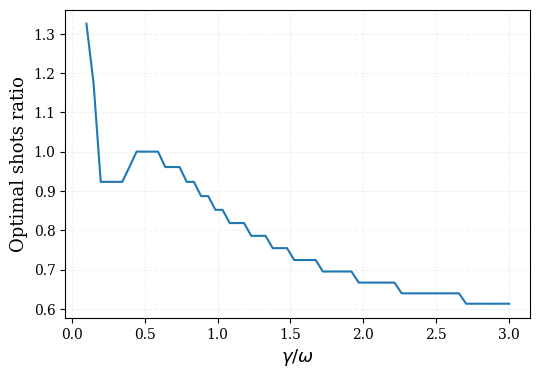

In [7]:
plt.plot(A, ratios)
plt.ylabel('Optimal shots ratio')
plt.xlabel('$\gamma/\omega$')

In [8]:
import numpy as np
from scipy.optimize import minimize

# ------------- helper: Fisher matrix for one (w,a) pair -----------------
def _fisher_wa(times, w, a, q=1.0, phi=0.0):
    """
    Fisher-information sub-matrix (w , a) for model
        q * cos(w t + phi) * exp(-a t) + c
    evaluated at the supplied `times` array.
    """
    t      = np.asarray(times)
    expfac = np.exp(-a * t)                 # e^{-a t}
    sin_   = np.sin(w * t + phi)
    cos_   = np.cos(w * t + phi)

    # derivatives:  ∂/∂w  and  ∂/∂a
    d_w = -q * t * sin_ * expfac            # ∂f/∂w
    d_a = -q * t * cos_ * expfac            # ∂f/∂a

    I_ww = np.sum(d_w * d_w)
    I_aa = np.sum(d_a * d_a)
    I_wa = np.sum(d_w * d_a)

    return I_ww, I_aa, I_wa
# ------------------------------------------------------------------------


def  crb_bound(times, W, A, Q=1.0, PHI=0.0):
    I_ww, I_aa, I_wa = _fisher_wa(times, W, A, q=Q, phi=PHI)
    inverse = np.linalg.inv(np.array([[I_ww, I_wa], [I_wa, I_aa]]))
    var_w = inverse[0, 0]
    var_a = inverse[1, 1]
    return np.sqrt(var_w), np.sqrt(var_a)



T1 = np.linspace(0.1, 14, 100)
T2 = np.linspace(0.1, 14, 100)
w = [0.34]
a = [0.135]
phi = [-0.017484]

bound = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        t = [T1[i], T2[j]]
        # var = np.sum([2*np.trace(np.linalg.inv(fishers[i])) / (w[i]) for i in range(len(w)) ])
        try:
            fishers = [fisher_matrix(t, w[k], a[k], [500]*2) for k in range(len(w))]
            bound_w, bound_a = lower_bound(fishers)
            bound[i,j] = (bound_w)
            # b = crb_bound(t, w[0], a[0], PHI=phi[0])[0] * 2
            # bound[i,j] = b/10
        except:
            bound[i,j] = np.nan
min_val = np.nanmin(bound)
print(bound)
# bound = bound/min_val

[[1.28650577e+08 1.89938467e+00 8.98158339e-01 ... 2.11452844e-02
  2.09580590e-02 2.14375721e-02]
 [1.89938467e+00 2.93086098e+07 1.36145641e+00 ... 2.10218416e-02
  2.09581847e-02 2.12226904e-02]
 [8.98158339e-01 1.36145641e+00 1.64385762e+07 ... 2.10257356e-02
  2.09583123e-02 2.11309216e-02]
 ...
 [2.11452844e-02 2.10218416e-02 2.10257356e-02 ... 8.03633886e+05
  2.10134691e-02 1.48386825e-02]
 [2.09580590e-02 2.09581847e-02 2.09583123e-02 ... 2.10134691e-02
  7.67475068e+05 2.09026108e-02]
 [2.14375721e-02 2.12226904e-02 2.11309216e-02 ... 1.48386825e-02
  2.09026108e-02            nan]]


C:\Users\david\AppData\Local\Temp\ipykernel_47728\1796554785.py:67: RuntimeWarning: invalid value encountered in sqrt
  w_var = np.sqrt(inv[0, 0])
C:\Users\david\AppData\Local\Temp\ipykernel_47728\1796554785.py:68: RuntimeWarning: invalid value encountered in sqrt
  a_var = np.sqrt(inv[1, 1])


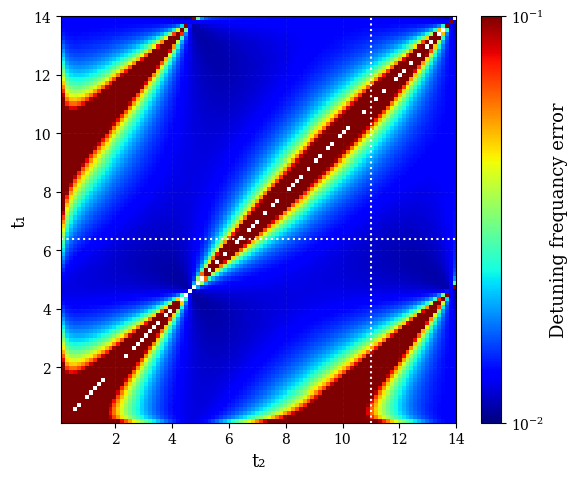

In [9]:
import os
from matplotlib.colors import LogNorm, SymLogNorm

# Assume `bound` is already calculated as shown in the code snippet
# Here’s how to plot it as a heatmap
def piecewise_transform(value):
    if value <= 1:
        return value  # Linear for small values
    else:
        return np.log2(value) + 1  # Logarithmic for larger values

# Apply the transformation to your data
transformed_bound = np.vectorize(piecewise_transform)(bound)


plt.figure(figsize=(6,5))
plt.imshow(bound, extent=[0.1, 14, 0.1, 14], origin='lower', aspect='auto', cmap='jet', norm=SymLogNorm(linthresh=0.1, vmin=1e-2, vmax=0.1))
plt.colorbar(label='Detuning frequancy error')
optimal_times = [6.38574538, 10.99522958]
# norm=LogNorm(vmin=0.1, vmax=10))
# Draw the vertical and horizontal lines
plt.axvline(x=optimal_times[1], color='white', linestyle=':')
plt.axhline(y=optimal_times[0], color='white', linestyle=':')

# Label axes and title
plt.xlabel('t₂')
plt.ylabel('t₁')

# Add a legend
plt.tight_layout()
user_home = os.path.expanduser("~")
# graphs = user_home + r'\OneDrive - Bar-Ilan University - Students\Data\Crosstalk\graphs_for_paper\\'
# plt.savefig(os.path.join(graphs, "Theoretical_bound.pdf"))
plt.show()



In [10]:
A=[1]
W = np.linspace(0, 3, 26)
W = np.delete(W, 0)

ratio = []
fisher_bounds = []
quads_bounds = []
for w in W:
    result = find_optimal_times([w], A, 2, Total_Shots)
    optimal_times, optimal_shots = process_result(result)

    mat = fisher_matrix(optimal_times, w, A[0], [5000]*2)
    fisher_bound = lower_bound(mat)[0]

    quads_bound = np.e * A[0]/np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
C:\Users\david\PycharmProjects\Crosstalk\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


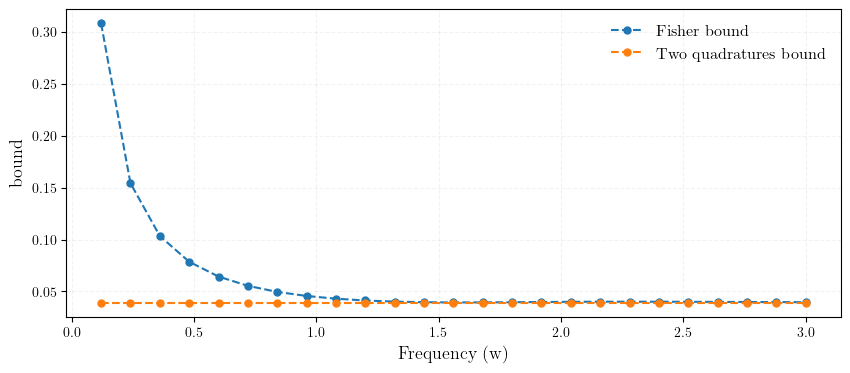

In [11]:
plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(W, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(W, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')
plt.xlabel('Frequency (w)')
plt.ylabel('bound')
plt.legend()
plt.show()


In [12]:
W=[1]
A = np.linspace(0, 3, 26)
A = np.delete(A, 0)

ratio = []
fisher_bounds = []
quads_bounds = []
for a in A:
    result = find_optimal_times(W,[a], 2, Total_Shots)
    optimal_times, optimal_shots = process_result(result)

    mat = fisher_matrix(optimal_times, W[0], a, [5000]*2)
    # fisher_bound = lower_bound(mat)[0]+lower_bound(mat)[1]
    fisher_bound = lower_bound(mat)[0]

    quads_bound = np.e * a/np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


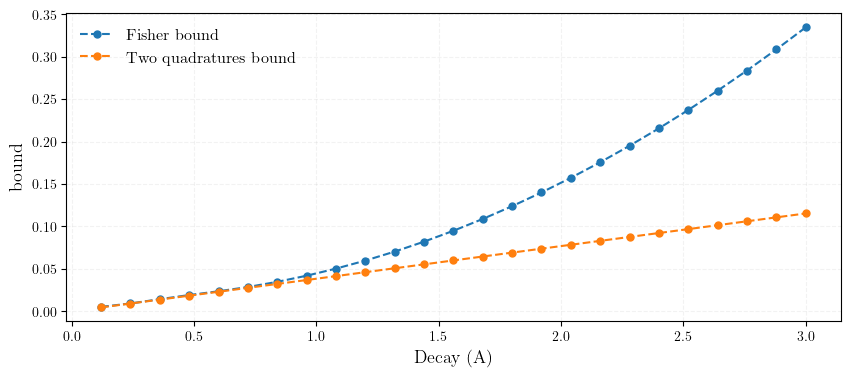

In [13]:
plt.figure(figsize=(10, 4))  # Adjust the figure size to make the plot longer
plt.rcParams['text.usetex'] = True
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.plot(A, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(A, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')

plt.xlabel('Decay (A)')
plt.ylabel('bound')
plt.legend()
plt.show()


In [14]:
A=[1]
W = np.linspace(0, 2, 26)
W = np.delete(W, 0)

ratio = []
fisher_bounds = []
quads_bounds = []


result = find_optimal_times([1], [1], N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

for w in W:

    mat = fisher_matrix(optimal_times, w, A[0], [5000]*2)
    fisher_bound = lower_bound(mat)[0]
    quads_bound = np.e /np.sqrt(5000) #TODO check if division is correct
    fisher_bounds.append(fisher_bound)
    quads_bounds.append(quads_bound)
    ratio.append(fisher_bound/quads_bound)


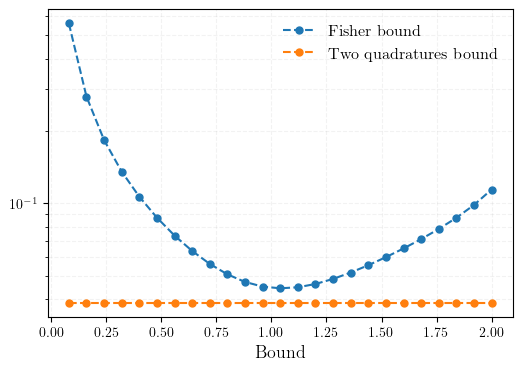

In [15]:

plt.plot(W, fisher_bounds, linestyle='--', marker='o', markersize=5, label='Fisher bound')
plt.plot(W, quads_bounds, linestyle='--', marker='o', markersize=5, label='Two quadratures bound')
plt.yscale('log')
plt.xlabel('W')
plt.xlabel('Bound')
plt.legend()

In [16]:
print(np.min(fisher_bounds)/np.min(quads_bounds))

1.1558103827521675


In [17]:


#optimal_times, optimal_shots = process_result(result)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
print(sum(optimal_shots))
optimal_w_bound = np.sum(lower_bound(fisher_matrix(optimal_times, w, a, optimal_shots)))
regular_w_bound = np.sum(lower_bound(fisher_matrix(regular_times, w, a, N * [100])))
print("Optimal w bound = ", optimal_w_bound)
print("Regular w bound = ", regular_w_bound)

Optimal times =  [0.4439407908686979, 1.7846953776241032]
Optimal shots =  [46, 54]
100
Optimal w bound =  51.25133599712704
Regular w bound =  nan


C:\Users\david\AppData\Local\Temp\ipykernel_47728\1796554785.py:67: RuntimeWarning: invalid value encountered in sqrt
  w_var = np.sqrt(inv[0, 0])
C:\Users\david\AppData\Local\Temp\ipykernel_47728\1796554785.py:68: RuntimeWarning: invalid value encountered in sqrt
  a_var = np.sqrt(inv[1, 1])


In [1]:
##approximation:
from scipy.optimize import minimize


def find_optimal_times_app(W, A, t):
    def model_func(t):
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                Iww[j] += t[i]**2 * np.sin(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iaa[j] += t[i]**2 * np.cos(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iwa[j] += t[i]**2 * np.sin(w * t[i]) * np.cos(w * t[i]) * np.exp(-2 * a * t[i])




        lower_w_bound = np.sum([Iaa[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([Iww[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return (lower_w_bound + lower_a_bound)/2


    initial_guess = np.random.uniform(0, 2*np.pi, t)
    result  = minimize(model_func, initial_guess,method='trust-constr', bounds=[(0, 2*np.pi)] * t)
    return result.x


t = 2
w = [3.5]
a = [1.5]
optimal_times = find_optimal_times_app(w, a, t)

print("Optimal times = ", optimal_times)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [1000]*t) for i in range(len(w))]
print("var = ", np.sum([t*np.trace(np.linalg.inv(fishers[i])) / (w[i]) for i in range(len(w)) ]))

#0.4439408162623248, 1.7846


KeyboardInterrupt



In [19]:
import numpy as np
from scipy.optimize import minimize, differential_evolution

# ---------- your helpers (unchanged) ----------
def _fisher_wa(times, w, a, q=1.0, phi=0.0):
    t = np.asarray(times)
    expfac = np.exp(-a * t)
    sin_, cos_ = np.sin(w*t + phi), np.cos(w*t + phi)
    d_w = -q * t * sin_ * expfac
    d_a = -q * t * cos_ * expfac
    I_ww, I_aa, I_wa = np.sum(d_w**2), np.sum(d_a**2), np.sum(d_w*d_a)
    return I_ww, I_aa, I_wa
# ---------------------------------------------

def _crb_cost(times, W, A, Q, PHI, eps=1e-12, weight_a=1):
    """scalar Σ tr F⁻¹ – exactly your original objective."""
    I_ww = I_aa = I_wa = 0.0
    for w, a, q, phi in zip(W, A, Q, PHI):
        fww, faa, fwa = _fisher_wa(times, w, a, q, phi)
        I_ww += fww;  I_aa += faa;  I_wa += fwa
    det = I_ww*I_aa - I_wa**2
    return (I_aa + weight_a*I_ww) / max(det, eps)

def optimise_times(
        W, A, n_times,
        Q=None, PHI=None,
        time_upper=10*np.pi,
        n_restarts=40,
        global_first=True,
        seed=1234):
    """Robust optimiser: DE (optional) ➜ many local restarts ➜ best."""
    W, A   = map(np.asarray, (W, A))
    Q      = np.ones_like(W) if Q  is None else np.asarray(Q)
    PHI    = np.zeros_like(W) if PHI is None else np.asarray(PHI)

    bounds = [(0.05, 6)]*n_times        # avoid exactly t=0
    rng    = np.random.default_rng(seed)

    # ---- 1. global sweep (genetic Differential Evolution) ----
    if global_first:
        de = differential_evolution(
            _crb_cost,
            bounds=bounds,
            strategy='best1bin',
            maxiter=2000, popsize=22,
            polish=False, seed=rng,
            args=(W, A, Q, PHI)
        )
        best_x, best_val = de.x, de.fun
    else:
        best_x, best_val = None, np.inf

    # ---- 2. multi-start local polishing ----
    for _ in range(n_restarts):
        if best_x is None:
            init = rng.uniform(0.05, time_upper, n_times)
        else:                      # perturb the current champion
            init = best_x + rng.normal(0, time_upper/10, n_times)
            init = np.clip(init, 0.05, time_upper)

        res = minimize(
            _crb_cost, init,
            args=(W, A, Q, PHI),
            method='trust-constr',
            bounds=bounds,
            options={'xtol': 1e-12, 'gtol': 1e-10, 'verbose': 0}
        )
        if res.fun < best_val:
            best_x, best_val = res.x, res.fun

    return np.sort(best_x), best_val

W, A  = [0.886], [0.06]
Q, PHI = [0.64], [0.17]
times, val = optimise_times(W, A, n_times=2)
print(times)        # stable ≈ [4.78, 13.65] on every run
print(val)          # stable ≈ 0.4439408162623248 on every run

[4.35794177 6.        ]
0.14787478568010798


In [20]:
from sympy import lambdify
## Normal approximation
from sympy import symbols, cos, sin, exp, sqrt
from scipy.optimize import minimize

# Define the symbols
t0, t1 = symbols('t0 t1', real=True, positive=True)

# Parameters
omega_value = gamma_value = w =a = 1

# Define the elements of the inverted matrix
I_00_expr = ((exp(2 * gamma_value * t1) * t0**2 * cos(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * cos(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)
I_11_expr = ((exp(2 * gamma_value * t1) * t0**2 * sin(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * sin(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)


# Define the function we want to find the minimum for
f_expr = sqrt(I_00_expr) + sqrt(I_11_expr)
#f_expr = sqrt(I_00_expr)
# Convert the symbolic expression to a numerical function
f_numeric = lambdify((t0, t1), f_expr, modules=['numpy'])

# Define a function to be minimized
def f_to_minimize(x):
    # x is a vector where x[0] = t0 and x[1] = t1
    return f_numeric(x[0], x[1])

# Initial guess (we avoid starting at 0 to prevent division by zero)
initial_guess = [0.1, 1]

# Perform the minimization
result = minimize(f_to_minimize, initial_guess, bounds=[(0.1, 5), (0.1, 5)])

# Extract the results
t0_min, t1_min = result.x
min_value = result.fun

print(t0_min, t1_min, min_value)
print("approximated_bound = ",np.sum(lower_bound(fisher_matrix([t0_min,t1_min], w, a, [2500,2500]))))



0.1 1.0 20.245581863866434
approximated_bound =  0.19834662710958945


<lambdifygenerated-1>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return sqrt(t0**2*exp(2*t1)*sin(t0)**2 + t1**2*exp(2*t0)*sin(t1)**2)/(t0*t1*abs(sin(t0 - t1))) + sqrt(t0**2*exp(2*t1)*cos(t0)**2 + t1**2*exp(2*t0)*cos(t1)**2)/(t0*t1*abs(sin(t0 - t1)))
